**Задание**

Постройте модель, используя архитектуру со свёрточными слоями, для классификации Fashion MNIST. Итоговое качество (accuracy) должно быть не ниже 89,5.

In [ ]:
import torchvision as tv
from torchvision import transforms
from torchsummary import summary
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import classification_report

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**1) Скачайте тренировочную и тестовою часть датасета Fashion MNIST**

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.], [0.5])])
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 12470717.98it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 216435.59it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3924680.58it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6217183.12it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
#Делаем из переменных итераторы, которые делят датасет на батчи. Поставим batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

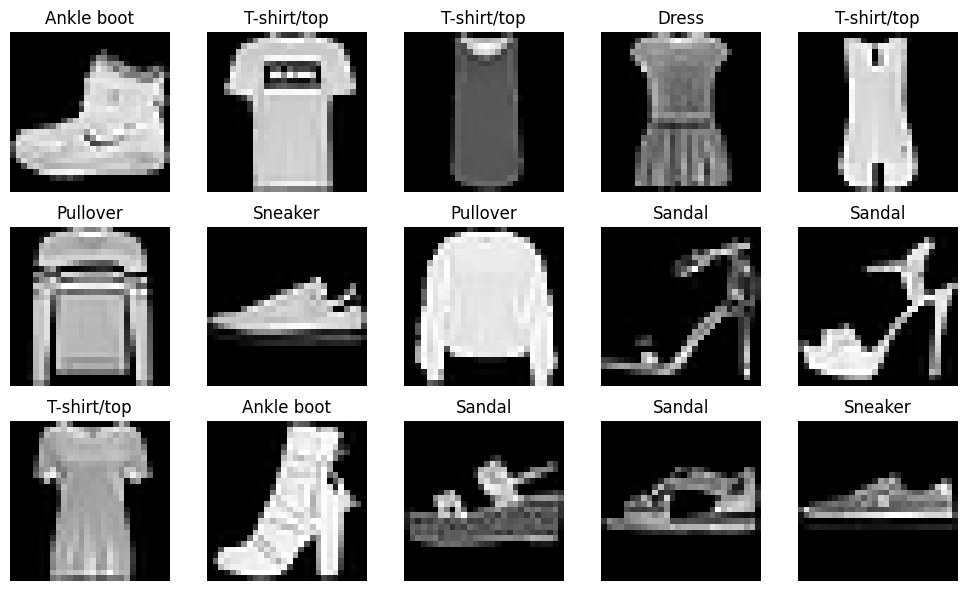

In [ ]:
# Создание подзаголовков для классов
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Создание сетки для изображений
rows, cols = 3, 5
num_images = rows * cols

# Создание новой фигуры для визуализации
fig = plt.figure(figsize=(10, 6))

for i in range(num_images):
    # Получение изображения и метки
    image, label = train_dataset[i]

    # Преобразование изображения в массив NumPy
    image = np.array(image)

    # Добавление подграфа
    ax = fig.add_subplot(rows, cols, i + 1)

    # Отключение осей
    ax.axis('off')

    # Отображение изображения
    ax.imshow(image.squeeze(), cmap='gray')

    # Добавление подписи с классом
    ax.set_title(classes[label])

# Вывод изображений
plt.tight_layout()
plt.show()


**2) Постройте архитектуру модели, используя свёрточные слои, слои регуляризации и один финальный полносвязный слой**

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64*6*6, out_features=1024)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)

        return out

In [ ]:
modelCNN = CNN()

In [ ]:
summary(modelCNN.to(device), input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 12, 12]          18,496
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Linear-9                 [-1, 1024]       2,360,320
        Dropout2d-10                 [-1, 1024]               0
           Linear-11                  [-1, 512]         524,800
           Linear-12                   [-1, 10]           5,130
Total params: 2,909,258
Trainable params: 2,909,258
Non-trainable params: 0
---------------------------

In [ ]:
class FashionMNISTClassifier:

    def __init__(self, learning_rate=0.03, num_epochs=5, device= device, model=None):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.device = torch.device(device)
        self.model = model.to(self.device) if model is not None else None
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)

    def evaluate_accuracy(self, data_loader, net):
        acc_sum, n = 0, 0
        net.eval()
        for X, y in data_loader:
            X, y = X.to(self.device), y.to(self.device)
            acc_sum += (net(X).argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        return acc_sum / n

    def fit(self, train_loader, test_loader):
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            start = time.time()

            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                print(f"\r{(int(i/len(train_loader)*100))+1}% ", end="", flush=True)

            test_acc = self.evaluate_accuracy(test_loader, self.model)
            train_acc = self.evaluate_accuracy(train_loader, self.model)

            print(f"Epoch: [{epoch+1}/{self.num_epochs}],Train loss:{running_loss/len(train_loader):.4f},"
            f"Time: {time.time() - start:.1f}sec., Train accuracy: {train_acc:.3f}, Test accuracy: {test_acc:.3f}")

    def predict(self, test_loader):
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for data in test_loader:
                inputs, _ = data
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())
        return predictions


**3) Обучите модель до необходимого качества. Если сеть не обучается до необходимого качества, попробуйте поменять архитектуру сети, варьируя параметры свёрток, количество каналов, количество свёрточных слоёв, слои регуляризации, тип оптимайзера и т. д.**

In [ ]:
clf = FashionMNISTClassifier(model = modelCNN, num_epochs=10)

In [ ]:
clf.fit(train_loader, test_loader)

100% Epoch: [1/10],Train loss:0.4196,Time: 28.3sec., Train accuracy: 0.877, Test accuracy: 0.863
100% Epoch: [2/10],Train loss:0.2806,Time: 28.1sec., Train accuracy: 0.906, Test accuracy: 0.893
100% Epoch: [3/10],Train loss:0.2415,Time: 27.7sec., Train accuracy: 0.917, Test accuracy: 0.900
100% Epoch: [4/10],Train loss:0.2158,Time: 27.9sec., Train accuracy: 0.922, Test accuracy: 0.899
100% Epoch: [5/10],Train loss:0.1959,Time: 28.6sec., Train accuracy: 0.929, Test accuracy: 0.906
100% Epoch: [6/10],Train loss:0.1768,Time: 31.1sec., Train accuracy: 0.936, Test accuracy: 0.909
100% Epoch: [7/10],Train loss:0.1619,Time: 27.7sec., Train accuracy: 0.944, Test accuracy: 0.913
100% Epoch: [8/10],Train loss:0.1483,Time: 28.0sec., Train accuracy: 0.945, Test accuracy: 0.910
100% Epoch: [9/10],Train loss:0.1336,Time: 28.3sec., Train accuracy: 0.950, Test accuracy: 0.911
100% Epoch: [10/10],Train loss:0.1219,Time: 29.1sec., Train accuracy: 0.952, Test accuracy: 0.912


Оценим качество модели

In [ ]:
pred = clf.predict(test_loader)

In [ ]:
test_labels = np.array(test_dataset.test_labels)

In [ ]:
print(classification_report(pred, test_labels))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      1069
           1       0.98      0.99      0.99       997
           2       0.85      0.88      0.86       960
           3       0.92      0.91      0.92      1017
           4       0.89      0.84      0.87      1060
           5       0.96      0.99      0.97       975
           6       0.71      0.80      0.75       891
           7       0.99      0.91      0.95      1091
           8       0.98      0.98      0.98      1000
           9       0.93      0.99      0.96       940

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

